# Earth Analytics Spring 2023 - Urban Heat Island Final Project
## Authors: Paula Pérez and Daniel Howard
## ECOSTRESS Data Download and Overview Product
The following Notebook contains a short workflow to download and process ECOSTRESS data from EarthExplorer with the Machine2Machine API. The intermediate outputs are H5 files corresponding to LST and Cloud Coverage for the selected study area, and the final outputs are raster image files of LST.

## Project Overview
This product was create in response to a research need proposed by the City of Boulder in Colorado to study Urban Heat Islands with high resolution. Their efforts are currently supported by the Jet Propulsion Lab, where researchers are hoping to downscale Land Surface Temperature (LST) data to a spatial resolution that informs local policy.

Urban Heat Islands are city phenomena caused by rapid urbanization and physical characteristics such as impervious materials and lack of vegetation. Not only do they have serious public health consequences, but they have also been proven to disproportionately impact socioeconommically vulnerable communities, such as low-income or racial minority communities.

Having downscaled data is crucial for city officials to address this issue with more just policies at a granular community level.

## Data sources
We use remote sensing data from the ECOSTRESS mission, specifically LST data provided in .h5 files. ECOSTRESS data comes in 70m resolution at an almost daily (but irregular) frequency. This product only processes ECOSTRESS LST data, but a future objective is to combine it with other demographic, socioeconomic and physical variables to better predict, and ultimately downscale, LST.

The study area boundary was obtained as a shapefile from the City of Boulder, and should be replaceable with other study areas if desired.

## State of current notebook
The current notebook is the first step in what will be a longer workflow. It includes code to download ECOSTRESS data and process it from an .h5 file to a geoTIFF.

However, both functionalities currently have some bugs. 
- The downloader obtains some files but sometimes crashes before downloading every scene, or takes too long to run (>1 hr) for few scenes. Test data can be [downloaded here](https://e4ftl01.cr.usgs.gov/ECOSTRESS/) to bypass this issue until it is addressed.
- The raw data processing is not pulling all necessary georeferencing data from the ECO1BGEO product to correct ECO2LSTE data.

## Setup
The first part of this product is to import the necessary libraries.

In [1]:
# Import libraries and set wd
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt

import numpy as np
import h5py
import requests
import os
import pathlib
import datetime
from dateutil import parser
import math
import pyproj
import earthaccess as ea

from pyresample import geometry as geom
from pyresample import kd_tree as kdt
from osgeo import gdal, gdal_array, osr
from shapely.geometry import mapping

Next, we set the working directory and output directory.

In [2]:
# Define working directory and downloads path
download_dir = os.path.join(
    pathlib.Path.home(), 
    "earth-analytics", 
    "data", 
    "uhi"
)

# Create directory if needed
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

# Define and create output directory as needed
out_dir = os.path.join(download_dir, 'geotiffs')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
# Change to downloads directory
os.chdir(download_dir)

# Confirm current working directory
os.getcwd()

'/Users/dhoward/earth-analytics/data/uhi'

## Study Area
The following cells load the study area boundary and plots it with its corresponding envelope. Other boundaries besides Boulder's in the same format will also work.

Boulder's city bounds are saved in the shapefile as five different polygons, so the calculated envelope is for the combined total bounds.

In [3]:
# Download Boulder city limits geojson file from REST API
url = ("https://maps.bouldercolorado.gov/arcgis/rest/services/plan/"
       "CityLimits/MapServer/0/query?outFields=*&where=1%3D1&f=geojson")
boulder_rest_api = requests.get(url)
fpath_boulder_limits_geojson = 'boulder_city_limits.geojson'
f = open(fpath_boulder_limits_geojson, 'wb')
f.write(boulder_rest_api.content)
f.close()

In [4]:
# Read in Boulder city limits as GeoDataFrame
boulder_limits_gdf = gpd.read_file(fpath_boulder_limits_geojson)

# Define Boulder city envelope
boulder_envelope_gdf = boulder_limits_gdf.unary_union.envelope
boulder_envelope_gdf = gpd.GeoDataFrame(
    geometry=gpd.GeoSeries(boulder_envelope_gdf)
)

minx, miny, maxx, maxy = boulder_envelope_gdf.total_bounds
boulder_polygon = boulder_envelope_gdf.geometry[0].exterior.coords[:]
boulder_envelope_gdf.total_bounds

array([-105.30145091,   39.95691668, -105.17809882,   40.09448471])

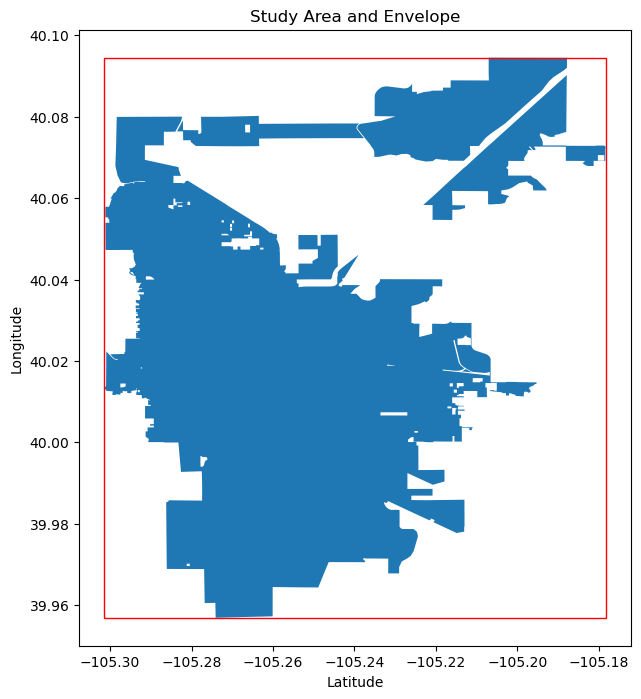

In [5]:
# Plot perimeter and envelope
fig, ax = plt.subplots(figsize=(12, 8))
boulder_limits_gdf.plot(ax=ax)
boulder_envelope_gdf.plot(facecolor='none', edgecolor='red', ax=ax)
ax.set(title='Study Area and Envelope', xlabel="Latitude", ylabel="Longitude")
plt.show()

Above, the political boundary of Boulder city is clearly seen in blue with the encompassing rectangular envelope surrounding is in red.

## NASA EarthData Download via `earthaccess` Package
Using the package ['earthaccess'](https://github.com/nsidc/earthaccess/), download data from NASA's [EARTHDATA](https://www.earthdata.nasa.gov/) Earth Science Data Systems (ESDS) program. It is recommended to search EarthData collections, datasets, and granules on the [EarthData Search web interface](https://search.earthdata.nasa.gov/search) prior to modifying download queries below.


To begin, authenticate with a EarthData login account, which can be created at [http://urs.earthdata.nasa.gov](http://urs.earthdata.nasa.gov).

In [6]:
auth = ea.login()

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
No .netrc found in /Users/dhoward


Enter your Earthdata Login username:  FinalDanish
Enter your Earthdata password:  ········


You're now authenticated with NASA Earthdata Login
Using token with expiration date: 07/09/2023
Using user provided credentials for EDL


Per the [`earthaccess` API Documentation](https://nsidc.github.io/earthaccess/user-reference/api/api/#earthaccess.api.search_datasets), search for ECOSTRESS LSTE and GEO granules that intersect with Boulder's city boundary. The LSTE granules contain the actual land surface temperature and emissivity band measurements while the GEO granules contain the georeferencing information for the associated granules in the ECOSTRESS project.

A narrow temporal range is pre-defined in order to include a known granule with good data quality. Note that this package does not accurately display yet the download size of each granule.

In [7]:
# Define temporal range to search for satellite measurement granules
start_date = "2021-06-17 21:09:00"
end_date = "2021-06-17 21:10:00"

# Run granule search query
boulder_granule_results = ea.search_data(
    short_name=["ECO2LSTE", "ECO1BGEO"],
    polygon=boulder_polygon,
    temporal=(start_date, end_date)
)
# Future searches may include ECO2CLD product for cloud cover
# An additional parameter `cloud_cover` can be passed above to filter granules 
# based on degree of cloud cover and data quality.

# Display summary information for each granule found
[display(granule) for granule in boulder_granule_results]

Granules found: 2


Collection: {'EntryTitle': 'ECOSTRESS Geolocation Daily L1B Global 70m V001'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -109.94883, 'EastBoundingCoordinate': -103.912033, 'NorthBoundingCoordinate': 43.266033, 'SouthBoundingCoordinate': 38.074463}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2021-06-17T21:09:39.270Z', 'EndingDateTime': '2021-06-17T21:10:31.240Z'}}
Size(MB): 0
Data: ['https://e4ftl01.cr.usgs.gov//ECOA/ECOSTRESS/ECO1BGEO.001/2021.06.17/ECOSTRESS_L1B_GEO_16719_009_20210617T210938_0601_02.h5']

Collection: {'EntryTitle': 'ECOSTRESS Land Surface Temperature and Emissivity Daily L2 Global 70m V001'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -109.94883, 'EastBoundingCoordinate': -103.912033, 'NorthBoundingCoordinate': 43.266033, 'SouthBoundingCoordinate': 38.074463}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2021-06-17T21:09:39.270Z', 'EndingDateTime': '2021-06-17T21:14:39.270Z'}}
Size(MB): 0
Data: ['https://e4ftl01.cr.usgs.gov//ECOB/ECOSTRESS/ECO2LSTE.001/2021.06.17/ECOSTRESS_L2_LSTE_16719_009_20210617T210938_0601_02.h5']

[None, None]

Since every __LSTE granule is each about 650 MB and GEO granule is about 1.1 GB__, count the number of granules to download by checking which granule HDF5 files already have been downloaded.

In [8]:
granules_to_download = 0

for g in boulder_granule_results:
    if not os.path.isfile(g.data_links()[0].split(os.sep)[-1]):
        granules_to_download+= 1
        
print("Number of granules to download: " + str(granules_to_download))

Number of granules to download: 0


Finally, download the granules to the desired local path. The `earthaccess.download()` function autmatically checks for and skips file downloads if the file exists.

Again, download size and progress bars are inaccurate. Thus, the download may appear frozen but are in fact proceeding. For faster downloads, consider download from cloud S3 buckets or streaming files as described in this [Introducing NASA `earthaccess` Tutorial](https://earthdata.readthedocs.io/en/latest/tutorials/demo/).

In [9]:
boulder_granule_files = ea.download(
    boulder_granule_results, 
    local_path=download_dir
)

 Getting 2 granules, approx download size: 0.0 GB


SUBMITTING | :   0%|          | 0/2 [00:00<?, ?it/s]

File ECOSTRESS_L1B_GEO_16719_009_20210617T210938_0601_02.h5 already downloadedFile ECOSTRESS_L2_LSTE_16719_009_20210617T210938_0601_02.h5 already downloaded



PROCESSING | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/2 [00:00<?, ?it/s]

## Raw data processing
The ECOSTRESS data is downloaded as individual .h5 files for each scene. While this means they don't need any kind of uncompressing, they have to be processed before being a useable GeoDataFrame.

The following code is based off of the [ECOSTRESS Swath To Grid Conversion Script](https://git.earthdata.nasa.gov/projects/LPDUR/repos/ecostress_swath2grid/browse) provided by NASA's LP DAAC. The original script is meant to be called through the command line, but different functions were copied and adapted below to run inline in this product and convert .h5 files into GeoTIFFs.

First, define some functions useful for raster processing.

In [10]:
# Define function to determine which UTM zone to use
def utmLookup(lat, lon):
    utm = str((math.floor((lon + 180) / 6) % 60) + 1)
    if len(utm) == 1:
        utm = '0' + utm
    if lat >= 0:
        epsg_code = '326' + utm
    else:
        epsg_code = '327' + utm
    return epsg_code

def getGeoLatLon(geo_file):
    # Retrieve list of geo datasets and extract lat/lon datasets
    geo_objs = []
    geo_file.visit(geo_objs.append)
    lat_sds = [str(o) for o in geo_objs 
               if isinstance(geo_file[o], h5py.Dataset) 
               and '/latitude' in o]
    lon_sds = [str(o) for o in geo_objs 
               if isinstance(geo_file[o], h5py.Dataset) 
               and '/longitude' in o]
    
    # Open latitude array
    lat = geo_file[lat_sds[0]][()].astype(float)  
    # Open longitude array
    lon = geo_file[lon_sds[0]][()].astype(float)  
    return [lat, lon]

Next, we search for and store file names of HDF5 files downloaded previously. 

Names of all LSTE and GEO data files will be displayed. These files should be 
available as matching pairs.

In [11]:
# Create lists of ECOSTRESS HDF-EOS5 files (geo, data) in the directory
geo_files = [f for f in os.listdir() 
             if f.startswith('ECO') and f.endswith('.h5') and 'GEO' in f]
lste_files = [f for f in os.listdir() 
             if f.startswith('ECO') and f.endswith('.h5') and 'LSTE' in f]

[geo_files, lste_files]

[['ECOSTRESS_L1B_GEO_23146_005_20220805T183439_0601_01.h5',
  'ECOSTRESS_L1B_GEO_22799_012_20220714T095907_0601_01.h5',
  'ECOSTRESS_L1B_GEO_16719_009_20210617T210938_0601_02.h5'],
 ['ECOSTRESS_L2_LSTE_23146_005_20220805T183439_0601_01.h5',
  'ECOSTRESS_L2_LSTE_16719_009_20210617T210938_0601_02.h5',
  'ECOSTRESS_L2_LSTE_22799_012_20220714T095907_0601_01.h5']]

The ECOSTRESS data is downloaded as individual .h5 files for each scene. While this means they don't need any kind of uncompressing, they have to be processed before being a useable GeoDataFrame.

The following code is based off of the [ECOSTRESS Swath To Grid Conversion Script](https://git.earthdata.nasa.gov/projects/LPDUR/repos/ecostress_swath2grid/browse) provided by NASA's LP DAAC. The original script is meant to be called through the command line, but for completeness and specificty, the script is copied and adapted below to run inline in this report and convert .h5 files into georeferenced GeoTIFFs.



In [12]:
for i, e in enumerate(lste_files):
    i += 1
    # Read in ECOSTRESS HDF5-EOS data file and store file name
    lste_file = h5py.File(e, "r")     
    lste_name = e.split('.h5')[0]
    
    # Retrieve list of datasets and extract SDS dataset names
    lste_objs = []
    lste_file.visit(lste_objs.append)          
    lste_sds = [str(o) for o in 
               lste_objs if isinstance(lste_file[o], h5py.Dataset)]
    
    # Subset for LST data only ### OPTION: Edit this for other SDS types desired
    lst_sds = [e for e in lste_sds if e.endswith('LST')]
    lste_tif_name = '{}_{}_{}.tif'.format(lste_name, 'LST', 'UTM')
    out_tif_path = os.path.join(out_dir, lste_tif_name)
    
    # Match ECOSTRESS GEO file to ECOSTRESS data file using
    # the orbit number, scene ID, and datetime of acquisition, i.e. e[-37:-10]
    geo_file_match = [g for g in geo_files if e[-37:-10] in g] 

    # CONVERT SWATH DATA TO GRID and IMPORT GEOLOCATION FILE
    # Proceed if matching GEO file found or geo data is in ECOSTRESS data file
    if len(geo_file_match) == 0 and 'L1B_MAP' not in e:   
        print('ECO1BGEO File not found for {}'.format(e))
        continue
    elif os.path.isfile(out_tif_path):
        print('Not processing file. ' + lste_tif_name + ' already exists.')
        continue
    else:
        print('Processing: {} ({} of {})'
              .format(e, str(i), str(len(lste_files)))
        )
        # Check ECOSTRESS data file already contains lat/lon or read in GEO file
        if 'L1B_MAP' in e:
            geo_file = lste_file                      
        else:
            geo_file = h5py.File(geo_file_match[0], "r")
        
        # Retrieve list of geo datasets and extract lat/lon arrays
        [lat, lon] = getGeoLatLon(geo_file)
        
        # Ensure lat array shape matches shape of datasets
        dims = lat.shape
        lst_sds = [s for s in lst_sds if lste_file[s].shape == dims]  
        # If no relevant datasets found, skip this data file
        if lst_sds == []:
            print('No matching SDS layers found for {}'.format(e))
            continue
            
        # SWATH TO GEOREFERENCED ARRAYS
        # Define swath given latitudes/longitudes
        swath_def = geom.SwathDefinition(lons=lon, lats=lat)
        mid_lat, mid_lon = np.mean(lat), np.mean(lon) 
        # Determine EPSG code for UTM zone
        epsg = utmLookup(mid_lat, mid_lon)

        # Don't use epsg:4326 AEQD projection since k-NN takes too long     
        # Instead, convert to UTM CRS per the UTM zone where data is located
        epsg_convert = pyproj.Proj("EPSG:{}".format(epsg))
        proj, proj_name = 'utm', 'Universal Transverse Mercator'
        proj_dict = {'proj': proj, 
                     'zone': epsg[-2:], 
                     'ellps': 'WGS84', 
                     'datum': 'WGS84', 
                     'units': 'm'}
        # Add dictionary entry for southern hemisphere UTM zones
        if epsg[2] == '7':
            proj_dict['south'] = 'True'
        ll_lon, ll_lat = epsg_convert(np.min(lon), np.min(lat))
        ur_lon, ur_lat = epsg_convert(np.max(lon), np.max(lat))
        area_extent = (ll_lon, ll_lat, ur_lon, ur_lat)
        # Per ECOSTRESS product, pixel size is 70 meters
        ps = 70.0
    
        # Calculate the output cols and rows
        cols = int(round((area_extent[2] - area_extent[0])/ps))
        rows = int(round((area_extent[3] - area_extent[1])/ps))
        
        # Setup projection and get neighbor info for kd tree 
        area_def = geom.AreaDefinition(epsg, proj_name, proj, proj_dict, 
                                       cols, rows, area_extent)
        # NOTE: `get_neighbour_info()` TENDS TO BE COMPUTATIONALLY EXPENSIVE
        index, outdex, index_arr, dist_arr = kdt.get_neighbour_info(
            swath_def, area_def, ps*3, neighbours=1)

    # LOOP THROUGH SDS CONVERT SWATH2GRID AND APPLY GEOREFERENCING
    for sds in lst_sds:
        # Create array and read dimensions
        lste_data = lste_file[sds][()]

        # Scale factor and add offset attribute names
        scale_name = [a for a in lste_file[sds].attrs if 'scale' in a.lower()]
        addoff_name = [a for a in lste_file[sds].attrs if 'offset' in a.lower()]

        # Read SDS attributes fill value, scale factor, and add off if available
        try:
            fill_value = int(lste_file[sds].attrs['_FillValue'])
        except KeyError:
            fill_value = None
        except ValueError:
            if lste_file[sds].attrs['_FillValue'] == b'n/a':
                fill_value = None
            elif type(lste_file[sds].attrs['_FillValue'][0]) == np.float32:
                fill_value = np.nan
            else:
                fill_value = lste_file[sds].attrs['_FillValue'][0]
        try:
            scale_factor = lste_file[sds].attrs[scale_name[0]][0]
        except:
            scale_factor = 1
        try:
            add_off = lste_file[sds].attrs[addoff_name[0]][0]
        except:
            add_off = 0

        # Perform kd tree resampling (swath 2 grid conversion)
        try:
            geo_data = kdt.get_sample_from_neighbour_info(
                'nn', area_def.shape, lste_data, 
                index, outdex, index_arr, fill_value=fill_value
            )
            ps = np.min([area_def.pixel_size_x, area_def.pixel_size_y])
            geotransform = [area_def.area_extent[0], ps, 0, 
                            area_def.area_extent[3], 0, -ps]
        except ValueError:
            continue

        # Apply Scale Factor and Add Offset
        geo_data = geo_data * scale_factor + add_off

        # Set fill value
        if fill_value is not None:
            geo_data[
                geo_data == fill_value * scale_factor + add_off] = fill_value

        # EXPORT GEOTIFFS
        out_name = '{}_{}_{}.tif'.format(lste_name, sds.rsplit('/')[-1], 'UTM')
        out_tif_path = os.path.join(out_dir, out_name)
        # Get driver, specify dimensions, define and set output geotransform
        height, width = geo_data.shape 
        driver = gdal.GetDriverByName('GTiff')
        data_type = gdal_array.NumericTypeCodeToGDALTypeCode(geo_data.dtype)
        d = driver.Create(out_tif_path, width, height, 1, data_type)
        d.SetGeoTransform(geotransform)

        # Create and set output projection, write output array data
        # Define target SRS
        srs = osr.SpatialReference()
        srs.ImportFromEPSG(int(epsg))
        d.SetProjection(srs.ExportToWkt())
        
        # Set band to write data into
        band = d.GetRasterBand(1)
        band.WriteArray(geo_data)

        # Define fill value if it exists, if not, set to mask fill value
        if fill_value is not None and fill_value != 'NaN':
            band.SetNoDataValue(fill_value)
        else:
            try:
                band.SetNoDataValue(int(geo_data.fill_value))
            except AttributeError:
                pass
            except TypeError:
                pass
            
        # Clear unecessary memory and cache
        band.FlushCache()
        d, band = None, None

Not processing file. ECOSTRESS_L2_LSTE_23146_005_20220805T183439_0601_01_LST_UTM.tif already exists.
Not processing file. ECOSTRESS_L2_LSTE_16719_009_20210617T210938_0601_02_LST_UTM.tif already exists.
Not processing file. ECOSTRESS_L2_LSTE_22799_012_20220714T095907_0601_01_LST_UTM.tif already exists.


## Clip and Display Land Surface Temperature Data for Boulder

For demonstration purposes, a pre-selected GeoTiff file is set to be processed. The historical weather report for that day as well as cloudiness level can be found at [WeatherSpark](https://weatherspark.com/h/d/3561/2021/6/17/Historical-Weather-on-Thursday-June-17-2021-in-Boulder-Colorado-United-States).

Future iterations of this project may identify additional or a series of images for analysis to highlight specific Urban Heat Island effects, ideally at mid-day measurement times with minimal cloud cover.

In [13]:
example_tif_path = os.path.join(
    out_dir, "ECOSTRESS_L2_LSTE_16719_009_20210617T210938_0601_02_LST_UTM.tif"
)
example_geo = rxr.open_rasterio(example_tif_path, masked=True)

Next, calculate the local overpass time to display with plot.

In [14]:
# Grab UTC time of observation from file name
passover_time = example_tif_path.split('_')[-5]
passover_time

# Convert UTC observation time to local overpass time.
observation_time = parser.parse(passover_time)
boulder_lon = boulder_envelope_gdf.total_bounds[0]
solar_overpass = observation_time + datetime.timedelta(
    hours=(np.radians(boulder_lon) / np.pi * 12)
)
local_overpass = datetime.time(solar_overpass.hour, solar_overpass.minute)
date = observation_time.strftime('%Y-%m-%d')
print(date, local_overpass)

2021-06-17 14:08:00


Now, clip the data and display results.

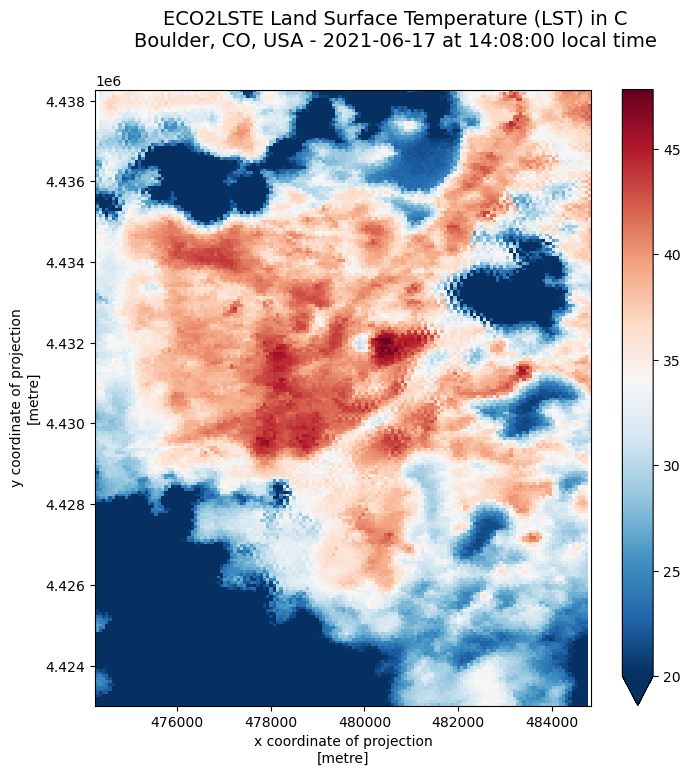

In [15]:
lste_clipped = example_geo.rio.clip(
    boulder_envelope_gdf.geometry.apply(mapping), 
    boulder_limits_gdf.crs) - 273.15

title = 'ECO2LSTE Land Surface Temperature'
fig, ax = plt.subplots(figsize=(8, 8))
fig.suptitle(
    f'{title} (LST) in C\n' + 
    f'Boulder, CO, USA - {date} at {local_overpass} local time', fontsize=14
)
lste_clipped.plot(cmap='RdBu_r', vmin=20, vmax=np.max(lste_clipped[0]).item())
ax.set_title('')
plt.show()

In the above plot, we see higher UHI effects along Pearl Street, North Broadway Holiday, and the 29th Street Mall/Boulder Junction areas. The neighborhoods of Wonderland Hills, Old North Boulder, Chautauqua, and Table Mesa (except the shopping and transit center) exhibit reduced UHI effects. This roughly correlates between high and low density neighborhoods of Boulder as well as areas without/with urban tree canopies. 

The highest intensity UHI, dark red, is found at the Boulder Munincipal Airport with the cooler Hayden Lake next to it. To note, the dark blue areas is not necessarily low UHI but rather cloud cover preventing accurate measurement of surface temperatures.

Since UHI and surface temperatures don't recognize political boundaries, the priovous plot is more informative. Nonetheless, the next plot isolates Boulder LST data to the official Boulder boundary only.

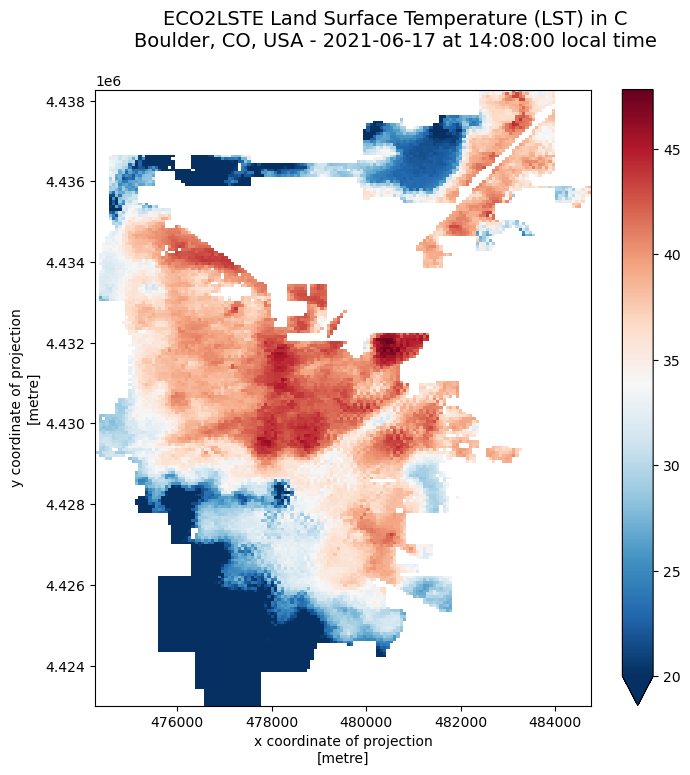

In [16]:
lste_clipped = example_geo.rio.clip(
    boulder_limits_gdf.geometry.apply(mapping), 
    boulder_limits_gdf.crs) - 273.15

title = 'ECO2LSTE Land Surface Temperature'
fig, ax = plt.subplots(figsize=(8, 8))
fig.suptitle(
    f'{title} (LST) in C\n' + 
    f'Boulder, CO, USA - {date} at {local_overpass} local time', fontsize=14
)
lste_clipped.plot(cmap='RdBu_r', vmin=20, vmax=np.max(lste_clipped[0]).item())
ax.set_title('')
plt.show()

## Review data

From the plots and ignoring cloud cover areas yet to be masked, it is immediately evident that the Urban Heat Island (UHI) effect is prominent within the developed areas of Boulder. To note, the accuracy of specific temperature intensities at any given point is not shown without using the SDS/LST_err dataset. Nonetheless, the general pattern of UHI is likely still valid. Given knowledge of Boulder city development patterns, the intensity of UHI is greatest at areas of Boulder with significant asphalt surface parking and minimal canopy cover.

This could be quantitatitevly verified with additional analysis that compare spatial NDVI data or image classification (for buildings, surface asphalt, vegetation, etc) with the LST data.

In order to downscale this data to hyperlocal scales, AI algorithms will likely require training on multiple images like this with sufficient data quality and minimal cloud cover. Given that an automated process is established above to both download and analyze sets of images, the process for procuring a large enough training set for such AI algorithms becomes feasible.

## Next Steps
Further development of this project should expect the addition of a workflow pipeline to automatically mask cloud cover in `ECO2LSTE` data swaths and select for swaths with minimal cloud cover within Boulder county. Showing side by side RGB images from `Sentinel-2` would also aid users of the notebook in assessing regional features that correlate with UHI effects.

Additional data sources, including _in situ_ air temperature measurements and surface albedo may be also incorporated into training approaches for a deep learning model to achieve downscaling goals of this project. A 2020 paper on such approaches can be reviewed here, [Using deep-learning to forecast the magnitude and characteristics of urban heat island in Seoul Korea](https://www.nature.com/articles/s41598-020-60632-z.pdf).

The authors look forward to any future work to achieve such goals.